In [3]:
!pip install opendatasets

In [9]:
import os
import pandas as pd
import opendatasets as od

# Set your API token directly (Paste the long string from your image)
os.environ['KAGGLE_API_TOKEN'] = "KGAT_41c727c0c2a8f7fe464218e1e6cd6d25"

# Now download the dataset
od.download("https://www.kaggle.com/datasets/brunogrisci/leukemia-gene-expression-cumida")

# Check if it worked
df = pd.read_csv('leukemia-gene-expression-cumida/Leukemia_GSE9476.csv')
df.head()


Skipping, found downloaded files in ".\leukemia-gene-expression-cumida" (use force=True to force download)


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,1,Bone_Marrow_CD34,7.745245,7.811210,6.477916,8.841506,4.546941,7.957714,5.344999,4.673364,...,5.058849,6.810004,12.800060,12.718612,5.391512,4.666166,3.974759,3.656693,4.160622,4.139249
1,12,Bone_Marrow_CD34,8.087252,7.240673,8.584648,8.983571,4.548934,8.011652,5.579647,4.828184,...,4.436153,6.751471,12.472706,12.333593,5.379738,4.656786,4.188348,3.792535,4.204414,4.122700
2,13,Bone_Marrow_CD34,7.792056,7.549368,11.053504,8.909703,4.549328,8.237099,5.406489,4.615572,...,4.392061,6.086295,12.637384,12.499038,5.316604,4.600566,3.845561,3.635715,4.174199,4.067152
3,14,Bone_Marrow_CD34,7.767265,7.094460,11.816433,8.994654,4.697018,8.283412,5.582195,4.903684,...,4.633334,6.375991,12.903630,12.871454,5.179951,4.641952,3.991634,3.704587,4.149938,3.910150
4,15,Bone_Marrow_CD34,8.010117,7.405281,6.656049,9.050682,4.514986,8.377046,5.493713,4.860754,...,5.305192,6.700453,12.949352,12.782515,5.341689,4.560315,3.887020,3.629853,4.127513,4.004316


In [5]:
# Check how many samples of each Leukemia type we have
print(df['type'].value_counts())

# Check for missing values
print(df.isnull().sum().sum())


type
AML                 26
Bone_Marrow         10
PB                  10
PBSC_CD34           10
Bone_Marrow_CD34     8
Name: count, dtype: int64
0


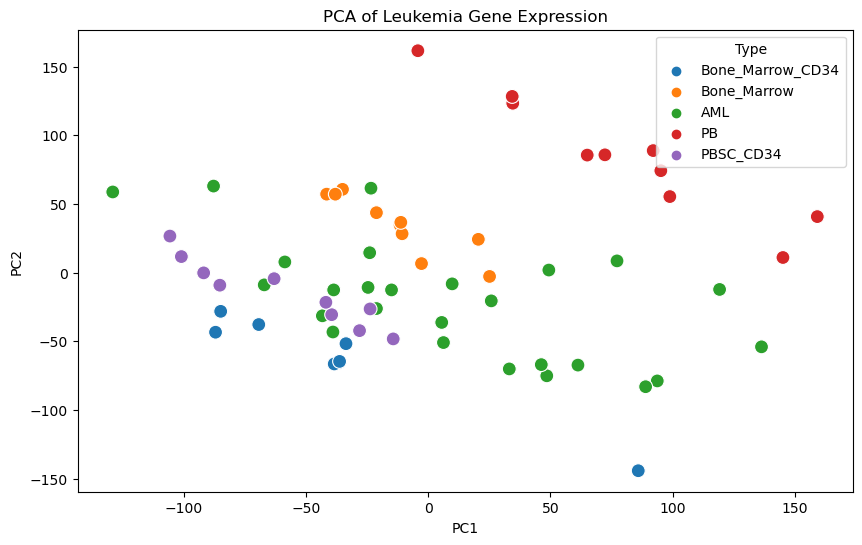

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data (Drop non-numerical columns)
# Note: 'samples' and 'type' are meta-data. Everything else is gene expression.
X = df.drop(columns=['samples', 'type'])
y = df['type'] # The labels

# 2. Standardize (Scale) the data
# This ensures genes with huge counts don't dominate the analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pca_df['Type'] = y

# 4. Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1', y='PC2', hue='Type', data=pca_df, s=100)
plt.title('PCA of Leukemia Gene Expression')
plt.show()


In [7]:
# Create a new dataframe with just AML and Normal Bone Marrow
comparison_df = df[df['type'].isin(['AML', 'Bone_Marrow'])]

# Get the mean expression for each gene in AML vs Bone Marrow
aml_means = comparison_df[comparison_df['type'] == 'AML'].drop(columns=['samples', 'type']).mean()
bm_means = comparison_df[comparison_df['type'] == 'Bone_Marrow'].drop(columns=['samples', 'type']).mean()

# Calculate the difference (AML - Bone Marrow)
diff = aml_means - bm_means

# Find the top 10 genes that are HIGHER in AML
top_genes = diff.sort_values(ascending=False).head(10)
print("Top Upregulated Genes in AML:")
print(top_genes)


Top Upregulated Genes in AML:
214651_s_at    3.133205
218280_x_at    3.038362
214290_s_at    2.908458
202708_s_at    2.601637
209905_at      2.356617
206674_at      2.249345
214455_at      2.169836
206310_at      2.154446
36711_at       2.078482
222067_x_at    1.988100
dtype: float64


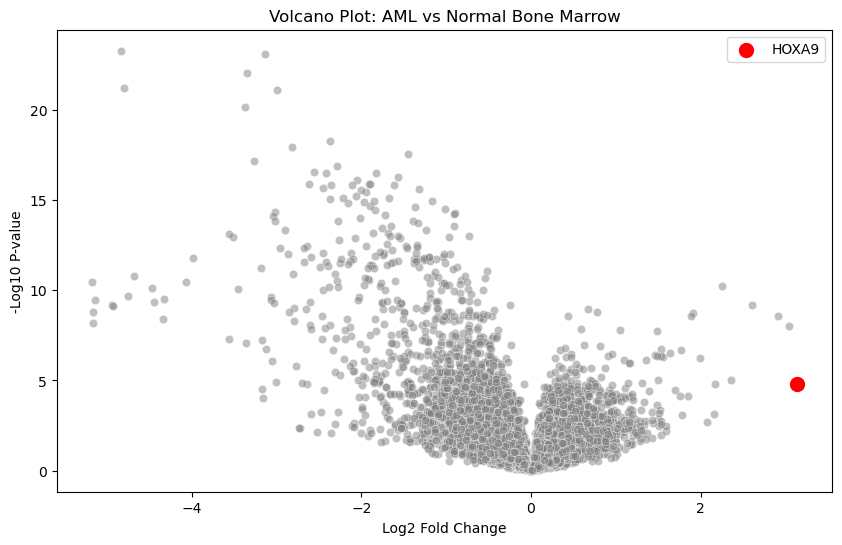

In [8]:
from scipy import stats
import numpy as np

# 1. Calculate P-values
# We run a T-test for every gene (columns) between AML and Bone Marrow
# This might take 10-20 seconds to run
p_values = []
genes = X.columns

group1 = X[y == 'AML']
group2 = X[y == 'Bone_Marrow']

for gene in genes:
    t_stat, p_val = stats.ttest_ind(group1[gene], group2[gene])
    p_values.append(p_val)

# 2. Create Results DataFrame
results = pd.DataFrame({
    'Gene': genes,
    'Log2FC': diff.values, # This is our difference from before
    'P_Value': p_values
})

# 3. Calculate -Log10(P-value) for the plot
results['nlog10p'] = -np.log10(results['P_Value'])

# 4. Plot Volcano
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='Log2FC', y='nlog10p', color='grey', alpha=0.5)

# Highlight HOXA9 (214651_s_at) in Red
highlight = results[results['Gene'] == '214651_s_at']
plt.scatter(highlight['Log2FC'], highlight['nlog10p'], color='red', s=100, label='HOXA9')

plt.title('Volcano Plot: AML vs Normal Bone Marrow')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.legend()
plt.show()
